In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
!ls "/content/drive/My Drive/Kvasir-SEG"
#!ls "/content/drive/Shared with me/EC523Project"

images	kavsir_bboxes.json  masks


# Training and Test Datasets

**Load the Data**

In [ ]:
import torch

In [ ]:
from torch.utils.data import Dataset
from PIL import Image
import os

class CustomDataset(Dataset):
    def __init__(self, image_dir, mask_dir):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.images = os.listdir(image_dir)
        self.transform = CustomTransforms(size=(350, 350))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_path = os.path.join(self.image_dir, self.images[idx])
        mask_path = os.path.join(self.mask_dir, self.images[idx])

        image = Image.open(image_path).convert('RGB')
        mask = Image.open(mask_path).convert('L')

        image, mask = self.transform(image, mask)

        return image, mask


In [ ]:
import torchvision.transforms.functional as TF
from torchvision import transforms
import random

class CustomTransforms:
    def __init__(self, size):
        self.size = size
        self.affine = transforms.RandomAffine(degrees=(-30, 30), translate=(0.1, 0.1), scale=(0.9, 1.1), shear=(-10, 10))

    def __call__(self, image, mask):
        # Resize
        image = TF.resize(image, self.size)
        mask = TF.resize(mask, self.size)

        # Random horizontal flipping
        if random.random() > 0.5:
            image = TF.hflip(image)
            mask = TF.hflip(mask)

        # Random vertical flipping
        if random.random() > 0.5:
            image = TF.vflip(image)
            mask = TF.vflip(mask)

        # Random rotation
        angle = random.randint(-30, 30)
        image = TF.rotate(image, angle)
        mask = TF.rotate(mask, angle)

        # Random affine transformation
        seed = random.random()
        random.seed(seed)  # Ensure image and mask receive the same random affine transformation
        image = self.affine(image)
        random.seed(seed)  # Re-seed
        mask = self.affine(mask)
        # Color Jitter
        if random.random() > 0.5:
            color_jitter = transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.1)
            image = color_jitter(image)

        # Gaussian Blur
        if random.random() > 0.5:
            image = TF.gaussian_blur(image, kernel_size=(5, 5))

        # Convert to tensor
        image = TF.to_tensor(image)
        mask = TF.to_tensor(mask)
        image = TF.normalize(image, mean=[0, 0, 0], std=[1, 1, 1])

        return image, mask


In [ ]:
from torch.utils.data import DataLoader, random_split
import torch

# Create the full dataset
dataset = CustomDataset(image_dir='/content/drive/My Drive/Kvasir-SEG/images',
                        mask_dir='/content/drive/My Drive/Kvasir-SEG/masks')

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

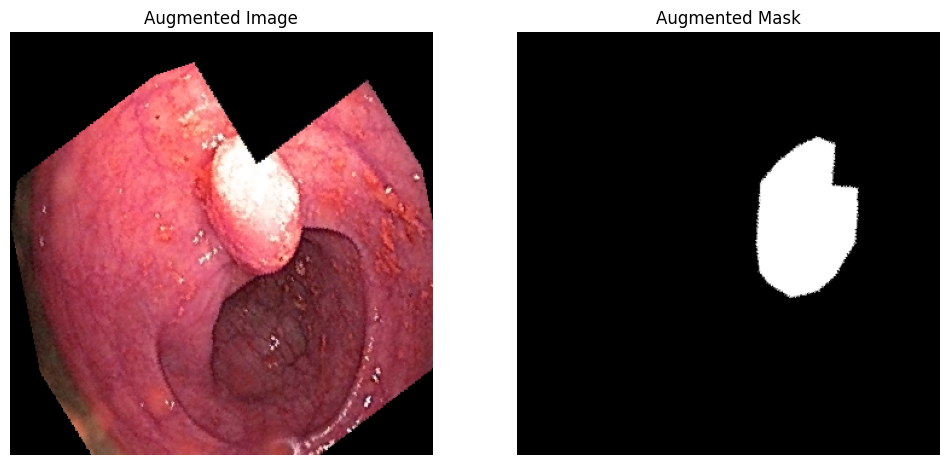

In [ ]:
import matplotlib.pyplot as plt
from torchvision import transforms
from torchvision.utils import make_grid

def visualize_augmentation(dataset, idx):
    """
    Visualize an augmented image and its mask from the dataset.

    Args:
    - dataset: Instance of the CustomDataset.
    - idx: Index of the image-mask pair in the dataset.
    """
    image, mask = dataset[idx]
    image_np = image.numpy().transpose(1, 2, 0)
    mask_np = mask.numpy().squeeze()
    image_np = (image_np - image_np.min()) / (image_np.max() - image_np.min())

    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    axs[0].imshow(image_np)
    axs[0].set_title("Augmented Image")
    axs[0].axis('off')

    axs[1].imshow(mask_np, cmap='gray')
    axs[1].set_title("Augmented Mask")
    axs[1].axis('off')

    plt.show()

dataset = train_dataset
visualize_augmentation(dataset, idx=0)

# TransUNet


## Architecture

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
from torch.nn import TransformerEncoder, TransformerEncoderLayer

class ResNetBackbone(nn.Module):
    def __init__(self):
        super(ResNetBackbone, self).__init__()
        resnet = models.resnet50(pretrained=True)
        resnet.conv1 = nn.Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

        self.layer0 = nn.Sequential(resnet.conv1, resnet.bn1, resnet.relu, resnet.maxpool)
        self.layer1 = resnet.layer1
        self.layer2 = resnet.layer2
        self.layer3 = resnet.layer3
        self.layer4 = resnet.layer4

    def forward(self, x):
        x0 = self.layer0(x)
        x1 = self.layer1(x0)
        x2 = self.layer2(x1)
        x3 = self.layer3(x2)
        x4 = self.layer4(x3)

        return x4, x3, x2, x1, x0

class TransformerBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, ff_dim, num_layers, dropout=0.1):
        super(TransformerBlock, self).__init__()
        encoder_layers = TransformerEncoderLayer(embed_dim, num_heads, ff_dim, dropout)
        self.transformer = TransformerEncoder(encoder_layers, num_layers)

    def forward(self, src):
        return self.transformer(src)

class ChannelAttention(nn.Module):
    def __init__(self, in_channels):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(in_channels, in_channels // 8, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(in_channels // 8, in_channels, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)



class UNetDecoder(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNetDecoder, self).__init__()
        # Adjust the stride and padding of the transposed convolutions as needed
        self.upconv1 = nn.ConvTranspose2d(in_channels, 1024, kernel_size=2, stride=2)
        self.conv1 = self._conv_block(3072, 1024)

        self.upconv2 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.conv2 = self._conv_block(1536, 512)

        self.final_upconv = nn.ConvTranspose2d(512, out_channels, kernel_size=2, stride=2)
        self.final_conv = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)

    def _conv_block(self, in_channels, out_channels):
        block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        return block

    def forward(self, x, x4, x3, x2, x1):
        device = x.device

        x = self.upconv1(x)
        x4_att = ChannelAttention(x4.size(1)).to(device)(x4)
        x4_att = F.interpolate(x4_att, size=(x.size(2), x.size(3)), mode='bilinear', align_corners=False)
        x = torch.cat((x, x4_att), dim=1)
        x = self.conv1(x)

        x = self.upconv2(x)
        x3_att = ChannelAttention(x3.size(1)).to(device)(x3)
        x3_att = F.interpolate(x3_att, size=(x.size(2), x.size(3)), mode='bilinear', align_corners=False)
        x = torch.cat((x, x3_att), dim=1)
        x = self.conv2(x)

        x = self.final_upconv(x)
        x = self.final_conv(x)

        return x



In [ ]:
import torch.nn.functional as F
class TransUNet(nn.Module):
    def __init__(self):
        super(TransUNet, self).__init__()
        self.backbone = ResNetBackbone()
        self.transformer = TransformerBlock(embed_dim=2048, num_heads=8, ff_dim=2048, num_layers=12)
        self.channel_adjust = nn.Conv2d(2048, 512, kernel_size=1)
        self.decoder = UNetDecoder(512, 1)

    def forward(self, x):

        x4, x3, x2, x1, x0 = self.backbone(x)
        bs, c, h, w = x4.shape

        x = x4.flatten(2).permute(2, 0, 1)  # Now shape is [sequence_length, batch_size, embedding_dim(2048)]
        x = self.transformer(x)
        x = x.permute(1, 2, 0).view(bs, -1, h, w)

        x = self.channel_adjust(x)
        x = self.decoder(x, x4, x3, x2, x1)

        # Interpolate to desired size
        x = F.interpolate(x, size=(350, 350), mode='bilinear', align_corners=False)

        return x



In [ ]:
num_classes = 3
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_epochs = 50

In [ ]:
# print(batch['image'].shape, batch['mask'].shape)

In [ ]:
# class DiceLoss(nn.Module):
#     def __init__(self):
#         super(DiceLoss, self).__init__()

#     def forward(self, input, target):
#         smooth = 1e-5
#         dice = 0.0
#         total = 0
#         unique_classes = torch.unique(target)
#         channels = input.shape[1]

#         if len(unique_classes) > 1:
#             for class_idx in unique_classes:
#                 idx = float(class_idx.item())
#                 for channel in range(channels):
#                     input_flat = (input[:, channel, :, :] == idx ).float().view(-1)
#                     target_flat = (target == idx).float().view(-1)
#                     intersection = torch.sum(input_flat * target_flat)
#                     dice_class = 1 - (2.0 * intersection + smooth) / (torch.sum(input_flat) + torch.sum(target_flat) + smooth)
#                     dice += dice_class
#                 total += 1

#         dice /= (total+1e-9)
#         # print("DICE", dice)
#         return dice



# class CombinedLoss(nn.Module):
#     def __init__(self, dice_weight=0.3):
#         super(CombinedLoss, self).__init__()
#         self.dice_loss = DiceLoss()
#         self.ce_loss = nn.CrossEntropyLoss()
#         self.dice_weight = dice_weight

#     def forward(self, input, target):

#         dice = self.dice_loss(input, target)

#         ce_target = target.max(dim=1)[1]
#         ce = self.ce_loss(input, ce_target)

#         # Combined Loss
#         combined = (self.dice_weight * dice) + ((1 - self.dice_weight) * ce)
#         return combined

class DiceLoss(nn.Module):
    def __init__(self):
        super(DiceLoss, self).__init__()

    def forward(self, input, target):
        smooth = 1e-5

        # Assuming input is sigmoid output [0,1]
        input_flat = input.view(-1)
        target_flat = target.view(-1)

        intersection = torch.sum(input_flat * target_flat)
        dice = 1 - (2. * intersection + smooth) / (torch.sum(input_flat) + torch.sum(target_flat) + smooth)
        return dice

class CombinedLoss(nn.Module):
    def __init__(self, dice_weight=0.3):
        super(CombinedLoss, self).__init__()
        self.dice_loss = DiceLoss()
        self.bce_loss = nn.BCEWithLogitsLoss()
        self.dice_weight = dice_weight

    def forward(self, input, target):
        dice = self.dice_loss(torch.sigmoid(input), target)
        bce = self.bce_loss(input, target)

        # Combined Loss
        combined = (self.dice_weight * dice) + ((1 - self.dice_weight) * bce)
        return combined



In [ ]:
def iou(pred_masks, true_masks):
    num_classes = pred_masks.shape[0]
    iou_sum = 0.0

    for class_idx in range(num_classes):
        pred_mask = pred_masks[class_idx]
        true_mask = true_masks[class_idx]

        intersection = torch.logical_and(pred_mask, true_mask).sum()
        union = torch.logical_or(pred_mask, true_mask).sum()
        iou = intersection / union
        iou_sum += iou

    mean_iou = iou_sum / num_classes
    return mean_iou

In [ ]:
import torch.optim as optim
# Initialize the model, loss function, and optimizer
model = TransUNet().to(device)
criterion = CombinedLoss()
optimizer = optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0001)


# Training loop
for epoch in range(num_epochs):
    total_iou = 0.0
    total_loss = 0.0
    num_samples = 0
    model.train()
    for images, masks in train_loader:
        images = images.to(device).float()
        masks = masks.to(device).float()

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(torch.sigmoid(outputs), masks)
        total_loss += loss.item()*images.size(0)

        iou_score = iou(torch.sigmoid(outputs), masks)
        total_iou += iou_score.item()*images.size(0)
        num_samples += images.size(0)

        loss.backward()
        optimizer.step()
        # print(f"Loss: {loss.item()}, IoU: {iou_score}")

    average_loss = total_loss / num_samples
    average_iou = total_iou / num_samples
    print(f"Epoch {epoch+1}/{num_epochs}, Average Loss: {average_loss:.4f}, Average IoU: {average_iou:.4f}")
    torch.save(model.state_dict(), '/content/drive/My Drive/transunet_model1_2.pth')


Epoch 1/50, Average Loss: 0.7351, Average IoU: 0.1599
Epoch 2/50, Average Loss: 0.7177, Average IoU: 0.1595
Epoch 3/50, Average Loss: 0.7174, Average IoU: 0.1598
Epoch 4/50, Average Loss: 0.7182, Average IoU: 0.1576
Epoch 5/50, Average Loss: 0.7181, Average IoU: 0.1582
Epoch 6/50, Average Loss: 0.7178, Average IoU: 0.1582
Epoch 7/50, Average Loss: 0.7176, Average IoU: 0.1592
Epoch 8/50, Average Loss: 0.7179, Average IoU: 0.1579
Epoch 9/50, Average Loss: 0.7180, Average IoU: 0.1588
Epoch 10/50, Average Loss: 0.7175, Average IoU: 0.1584
Epoch 11/50, Average Loss: 0.7177, Average IoU: 0.1593
Epoch 12/50, Average Loss: 0.7175, Average IoU: 0.1593
Epoch 13/50, Average Loss: 0.7177, Average IoU: 0.1598


## Validation

Load the saved models

In [ ]:
model1 = TransUNet().to(device)

# Load the saved state dictionary
model1.load_state_dict(torch.load('/content/drive/My Drive/transunet_model1_2.pth'))

# Don't forget to set the model to eval mode if you're doing inference
model1.eval()

TransUNet(
  (backbone): ResNetBackbone(
    (layer0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    )
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_segmentation(model, data_loader, device, threshold=0.5):
    model.eval()  # Set the model to evaluation mode

    with torch.no_grad():
        for images, masks in data_loader:
            images = images.to(device).float()
            masks = masks.to(device).float()

            # Get the model predictions
            predictions = model(images)
            #print(torch.sigmoid(predictions) > 0.5)

            # Convert predictions to binary masks
            predicted_masks = torch.sigmoid(predictions) < 0.0000000005
            num_true = torch.sum(predicted_masks).item()  # Counts the number of True values
            num_false = predicted_masks.numel() - num_true  # Total number of elements minus the number of True values

            print("Number of True values:", num_true)
            print("Number of False values:", num_false)

            images_np = images.cpu().squeeze().numpy()
            true_masks_np = masks.cpu().squeeze().numpy()
            predicted_masks_np = predicted_masks.cpu().squeeze().numpy()

            # Handle potential multiple images in a batch
            batch_size = images_np.shape[0]
            for i in range(batch_size):
                # Handle multi-channel images (e.g., RGB)
                if images_np.shape[1] == 3:  # Assuming channel-first format
                    img = np.transpose(images_np[i], (1, 2, 0))
                else:  # Single-channel image
                    img = images_np[i]

                true_mask = true_masks_np[i]
                pred_mask = predicted_masks_np[i]

                # Visualization
                plt.figure(figsize=(18, 6))

                plt.subplot(1, 3, 1)
                plt.imshow(img, cmap='gray')
                plt.title('Original Image')
                plt.axis('off')

                plt.subplot(1, 3, 2)
                plt.imshow(img, cmap='gray')
                plt.imshow(true_mask, cmap='jet')
                plt.title('Ground Truth Mask')
                plt.axis('off')

                plt.subplot(1, 3, 3)
                plt.imshow(img, cmap='gray')
                plt.imshow(pred_mask, cmap='jet')
                plt.title('Predicted Mask')
                plt.axis('off')

                plt.show()

                if i >= 6:
                    break

            break

visualize_segmentation(model1, train_loader, device)

In [ ]:
model1.eval()
total_loss = 0.0
total_iou = 0.0
num_samples = 0
criterion = nn.BCEWithLogitsLoss()

with torch.no_grad():
    for batch in train_loader:
        images = batch['image'].to(device).float()
        masks = batch['mask'].to(device).float()

        out = model1(images)
        loss = criterion(out, masks)

        iou_val = iou(out, masks)
        total_iou += iou_val * images.size(0)
        total_loss += loss.item() * images.size(0)
        num_samples += images.size(0)

average_loss = total_loss / num_samples
average_iou = total_iou / num_samples
print('Validation Loss: {:.4f}, Validation IoU: {:.4f}'.format(average_loss, average_iou))

KeyboardInterrupt: ignored

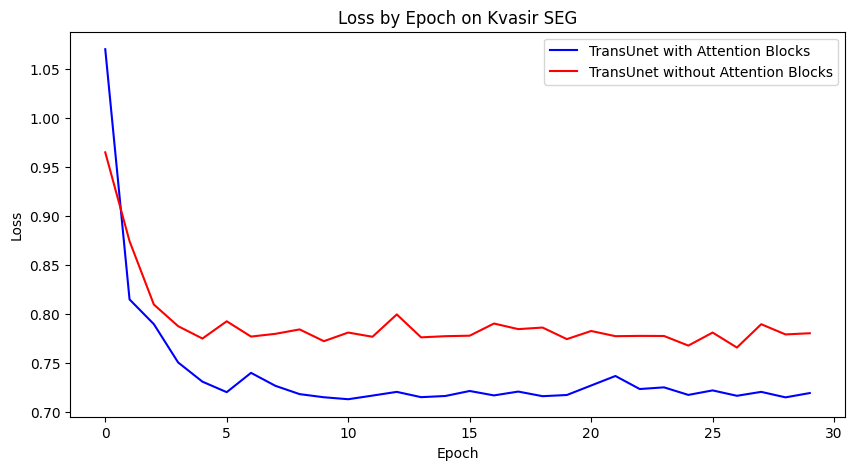

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(loss_res, label='TransUnet with Attention Blocks', color = 'blue')
plt.plot(loss_res2, label='TransUnet without Attention Blocks', color = 'red')

plt.title('Loss by Epoch on Kvasir SEG')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()


In [ ]:
model1 = TransUNet().to(device)

# Load the saved state dictionary
model1.load_state_dict(torch.load('/content/drive/My Drive/transunet_model1_2.pth'))

# Don't forget to set the model to eval mode if you're doing inference
model1.eval()

import matplotlib.pyplot as plt
import numpy as np

def visualize_segmentation(model, data_loader, device, threshold=0.5):
    model.eval()  # Set the model to evaluation mode

    with torch.no_grad():
        for images, masks in data_loader:
            images = images.to(device).float()
            masks = masks.to(device).float()

            # Get the model predictions
            predictions = model(images)
            #print(torch.sigmoid(predictions) > 0.5)

            # Convert predictions to binary masks
            predicted_masks = torch.sigmoid(predictions) > 0.0000001
            num_true = torch.sum(predicted_masks).item()  # Counts the number of True values
            num_false = predicted_masks.numel() - num_true  # Total number of elements minus the number of True values

            print("Number of True values:", num_true)
            print("Number of False values:", num_false)

            images_np = images.cpu().squeeze().numpy()
            true_masks_np = masks.cpu().squeeze().numpy()
            predicted_masks_np = predicted_masks.cpu().squeeze().numpy()

            # Handle potential multiple images in a batch
            batch_size = images_np.shape[0]
            for i in range(batch_size):
                # Handle multi-channel images (e.g., RGB)
                if images_np.shape[1] == 3:  # Assuming channel-first format
                    img = np.transpose(images_np[i], (1, 2, 0))
                else:  # Single-channel image
                    img = images_np[i]

                true_mask = true_masks_np[i]
                pred_mask = predicted_masks_np[i]

                # Visualization
                plt.figure(figsize=(18, 6))

                plt.subplot(1, 3, 1)
                plt.imshow(img, cmap='gray')
                plt.title('Original Image')
                plt.axis('off')

                plt.subplot(1, 3, 2)
                plt.imshow(img, cmap='gray')
                plt.imshow(true_mask, cmap='jet')
                plt.title('Ground Truth Mask')
                plt.axis('off')

                plt.subplot(1, 3, 3)
                plt.imshow(img, cmap='gray')
                plt.imshow(pred_mask, cmap='jet')
                plt.title('Predicted Mask')
                plt.axis('off')

                plt.show()

                if i >= 6:
                    break

            break

visualize_segmentation(model1, train_loader, device)

NameError: ignored